In [1]:
%matplotlib inline


# Inverting scattering via mse
This script aims to quantify the information loss for natural images by
performing a reconstruction of an image from its scattering coefficients via a
L2-norm minimization.


## Imports



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import optim
from scipy.misc import face

from kymatio.torch import Scattering2D

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load test image



/var/folders/7y/n8m7fb8j0zq8tgbywqdqb_fm0000gn/T/ipykernel_97326/4267053241.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  src_img = src_img.resize((512, 384), Image.ANTIALIAS)


Image shape:  (3, 384, 512)


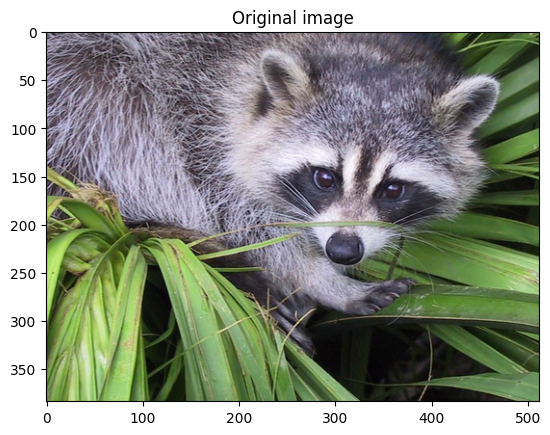

In [3]:
src_img = Image.fromarray(face())
src_img = src_img.resize((512, 384), Image.ANTIALIAS)
src_img = np.array(src_img).astype(np.float32)
src_img = src_img / 255.0
plt.imshow(src_img)
plt.title("Original image")

src_img = np.moveaxis(src_img, -1, 0)  # HWC to CHW
max_iter = 15 # number of steps for the GD
print("Image shape: ", src_img.shape)
channels, height, width = src_img.shape

## Main loop



Epoch 14, loss: 0.0010962294181808832
PSNR: 14.83dB for order 1 and J=2
Epoch 14, loss: 0.00026264900225214664
PSNR: 14.87dB for order 1 and J=4


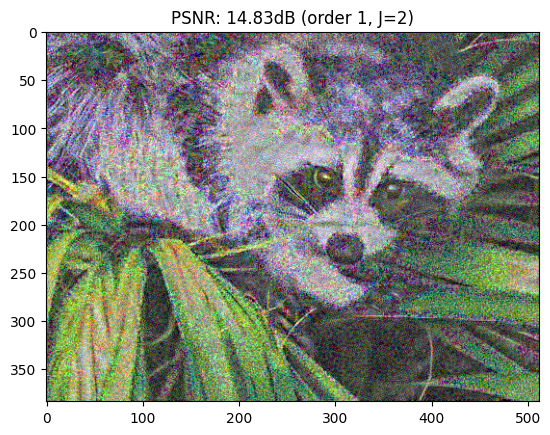

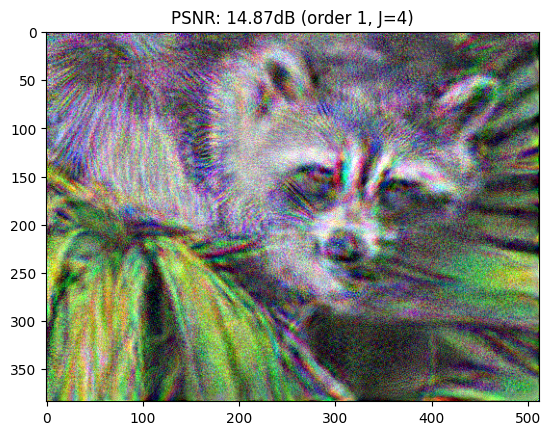

In [4]:
for order in [1]:
    for J in [2, 4]:

        # Compute scattering coefficients
        scattering = Scattering2D(J=J, shape=(height, width), max_order=order)
        if device == "cuda":
            scattering = scattering.cuda()
            max_iter = 500
        src_img_tensor = torch.from_numpy(src_img).to(device).contiguous()
        scattering_coefficients = scattering(src_img_tensor)

        # Create trainable input image
        input_tensor = torch.rand(src_img.shape, requires_grad=True, device=device)

        # Optimizer hyperparams
        optimizer = optim.Adam([input_tensor], lr=1)

        # Training
        best_img = None
        best_loss = float("inf")
        for epoch in range(1, max_iter):
            new_coefficients = scattering(input_tensor)
            loss = F.mse_loss(input=new_coefficients, target=scattering_coefficients)
            print("Epoch {}, loss: {}".format(epoch, loss.item()), end="\r")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if loss < best_loss:
                best_loss = loss.detach().cpu().item()
                best_img = input_tensor.detach().cpu().numpy()

        best_img = np.clip(best_img, 0.0, 1.0)

        # PSNR
        mse = np.mean((src_img - best_img) ** 2)
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        print("\nPSNR: {:.2f}dB for order {} and J={}".format(psnr, order, J))

        # Plot
        plt.figure()
        plt.imshow(np.moveaxis(best_img, 0, -1))
        plt.title("PSNR: {:.2f}dB (order {}, J={})".format(psnr, order, J))

plt.show()